In [1]:
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scrape_genius import get_lyrics_from_dataframe
import re
from  urllib import request
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [2]:
merged_df = pd.read_csv('genius_grammy.csv')

In [3]:
merged_df.dropna(inplace=True)

In [4]:
merged_df.title.nunique()

343

In [5]:
# Define regex pattern to match section headers and instances of the word "lyric"
pattern = r"\[(Chorus|choru|Intro|Verse \d+|Bridge|Outro)\]|\(SINGLE\)|[Ll][Yy][Rr][Ii][Cc][Ss]:?|\blyrics\b"

# Apply regex pattern to lyrics column in data frame
merged_df['lyrics'] = merged_df['lyrics'].apply(lambda x: re.sub(pattern, "", x))

# Print updated data frame
print(merged_df)


                               title                           artist  winner  \
0    Nel Blu Dipinto Di Blu (Volare)                 Domenico Modugno       1   
1               Catch A Falling Star                       Perry Como       0   
2                Witchcraft (Single)                    Frank Sinatra       0   
3                  The Chipmunk Song  David Seville And The Chipmunks       0   
4                     Fever (Single)                        Peggy Lee       0   
..                               ...                              ...     ...   
343                            Woman                         Doja Cat       0   
344           You And Me On The Rock  Brandi Carlile Featuring Lucius       0   
345            Good Morning Gorgeous                    Mary J. Blige       0   
346                       Easy On Me                            Adele       0   
347               Don't Shut Me Down                             ABBA       0   

     year                  

In [6]:
merged_df

,title,artist,winner,year,lyrics
0,Nel Blu Dipinto Di Blu (Volare),Domenico Modugno,1,1958,"Nel blu dipinto di blu (Volare) [Testo di ""Nel..."
1,Catch A Falling Star,Perry Como,0,1958,Catch a Falling Star \nCatch a falling star an...
2,Witchcraft (Single),Frank Sinatra,0,1958,Sweetest Maleficia [Gilles de Rais:]\nI conjur...
3,The Chipmunk Song,David Seville And The Chipmunks,0,1958,The Chipmunk song [Dave:] Alright you Chipmunk...
4,Fever (Single),Peggy Lee,0,1958,Jaden Smith Discography 2012\nFlame (Just Cuz)...
...,...,...,...,...,...
343,Woman,Doja Cat,0,2022,TranslationsTürkçeEspañolPortuguêsItalianoΕλλη...
344,You And Me On The Rock,Brandi Carlile Featuring Lucius,0,2022,You and Me On The Rock \nThey build wooden hou...
345,Good Morning Gorgeous,Mary J. Blige,0,2022,"Good Morning Gorgeous \nOoh\nOoh, ooh, ohh, ah..."
346,Easy On Me,Adele,0,2022,TranslationsTürkçeไทย / Phasa ThaiSvenskaEspañ...


In [7]:
def preprocess_text(text):
    # Tokenize the text into individual words
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Stem and lemmatize the words 
    porter = nltk.PorterStemmer()
    stemmed_tokens = [porter.stem(token) for token in filtered_tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text

merged_df['preprocessed_lyrics'] = merged_df['lyrics'].apply(preprocess_text)


In [8]:
# Identify language of each lyric using langdetect
merged_df['language'] = merged_df['preprocessed_lyrics'].apply(detect)

# Filter out non-English lyrics
df_english = merged_df[merged_df['language'] == 'en']


In [9]:
df_english.dropna(axis=1, inplace=True)

if df_english['preprocessed_lyrics'].dtype != 'object':
    df_english['preprocessed_lyrics'] = df_english['preprocessed_lyrics'].astype(str)

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66123/2351279597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english.dropna(axis=1, inplace=True)


In [10]:
df_english

,title,artist,winner,year,lyrics,preprocessed_lyrics,language
1,Catch A Falling Star,Perry Como,0,1958,Catch a Falling Star \nCatch a falling star an...,catch fall star catch fall star put pocket nev...,en
2,Witchcraft (Single),Frank Sinatra,0,1958,Sweetest Maleficia [Gilles de Rais:]\nI conjur...,sweetest maleficia [ gill de rai : ] conjur ba...,en
3,The Chipmunk Song,David Seville And The Chipmunks,0,1958,The Chipmunk song [Dave:] Alright you Chipmunk...,"chipmunk song [ dave : ] alright chipmunk , re...",en
4,Fever (Single),Peggy Lee,0,1958,Jaden Smith Discography 2012\nFlame (Just Cuz)...,jaden smith discographi 2012 flame ( cuz ) giv...,en
5,Mack The Knife,Bobby Darin,1,1959,"Mack the Knife Oh the shark, babe, has such te...","mack knife oh shark , babe , teeth , dear show...",en
...,...,...,...,...,...,...,...
343,Woman,Doja Cat,0,2022,TranslationsTürkçeEspañolPortuguêsItalianoΕλλη...,translationstürkçeespañolportuguêsitalianoελλη...,en
344,You And Me On The Rock,Brandi Carlile Featuring Lucius,0,2022,You and Me On The Rock \nThey build wooden hou...,rock build wooden hous frozen pond summertim w...,en
345,Good Morning Gorgeous,Mary J. Blige,0,2022,"Good Morning Gorgeous \nOoh\nOoh, ooh, ohh, ah...","good morn gorgeou ooh ooh , ooh , ohh , ah ooh...",en
346,Easy On Me,Adele,0,2022,TranslationsTürkçeไทย / Phasa ThaiSvenskaEspañ...,translationstürkçeไทย / phasa thaisvenskaespañ...,en


In [11]:
def read_lexicon(filename):
    word_sentiments = {}

    # Parse lexicon file
    with open(filename, 'r') as f:
        for line in f:
            # Ignore blank lines
            if line.strip():
                word, sentiment, value = line.split()
                if value == '1':
                    # Add sentiment to dictionary
                    cur_list = word_sentiments.get(word, [])
                    cur_list.append(sentiment)
                    word_sentiments[word] = cur_list

    return word_sentiments

In [12]:
def get_sentiment_percentages(track_df, sentiment):
    sentiment_pcts = []

    # Parse tracks
    for title in track_df.index.values:
        num_sentiment_words = 0
        all_words = str(track_df.loc[title]['preprocessed_lyrics']).split()

        # Parse words in lyrics
        for word in all_words:
            if sentiment in word_sentiments_dict.get(word, []):
                num_sentiment_words += 1

        sentiment_pcts.append(num_sentiment_words/len(all_words))

    return pd.DataFrame(data=sentiment_pcts, index=track_df.index.values, columns=[sentiment + '_pct'])


In [13]:
#Initialize sentiment dictionary and track dataframe
word_sentiments_dict = read_lexicon('lexicon.txt')

#Generate sentiment percentages based on NRC Lexicon sentiments
sentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for sentiment  in sentiments:
    sentiment_df = get_sentiment_percentages(df_english, sentiment)
    df_english = df_english.join(sentiment_df)

In [14]:
# Calculate the weighted average of the sentiment percentages for each row in the DataFrame
weights = [0.1, 0.5, 0.1, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1]
sentiments = ['negative_pct',
              'sadness_pct',
              'disgust_pct',
              'fear_pct',
              'anticipation_pct',
              'joy_pct', 
              'surprise_pct',
              'trust_pct',
              'anger_pct']
df_english[sentiments] = df_english[sentiments].replace(0, 0.000001) # take care of 0s
df_english['gloom_index'] = (df_english[sentiments] * weights).sum(axis=1)

# Rescale the 'gloom_index' column to a range of 0 to 100
max_gloom_value = df_english['gloom_index'].max()
min_gloom_value = df_english['gloom_index'].min()
df_english['gloom_index'] = (df_english['gloom_index'] - min_gloom_value) / (max_gloom_value - min_gloom_value) * 100

# Sort the DataFrame by the 'gloom_index' column in descending order
df_english.sort_values(by='gloom_index', ascending=False, inplace=True)



In [15]:
df_english[sentiments]

,negative_pct,sadness_pct,disgust_pct,fear_pct,anticipation_pct,joy_pct,surprise_pct,trust_pct,anger_pct
178,0.117647,0.076923,0.052036,0.095023,0.067873,0.049774,0.033937,0.063348,0.047511
311,0.097938,0.097938,0.082474,0.082474,0.030928,0.025773,0.015464,0.025773,0.082474
241,0.113208,0.094340,0.061321,0.070755,0.061321,0.042453,0.014151,0.047170,0.061321
83,0.110345,0.089655,0.027586,0.089655,0.055172,0.041379,0.013793,0.048276,0.020690
252,0.101818,0.065455,0.021818,0.065455,0.069091,0.047273,0.069091,0.054545,0.083636
...,...,...,...,...,...,...,...,...,...
328,0.024436,0.000001,0.000001,0.003759,0.011278,0.015038,0.007519,0.015038,0.000001
111,0.031746,0.000001,0.000001,0.000001,0.023810,0.015873,0.000001,0.007937,0.000001
92,0.003367,0.003367,0.003367,0.003367,0.003367,0.000001,0.003367,0.003367,0.003367
160,0.006536,0.000001,0.000001,0.000001,0.006536,0.006536,0.000001,0.013072,0.000001


In [16]:
df_english.drop_duplicates(['title','artist', 'year'], inplace=True)

In [17]:
df_english.sort_values(['gloom_index'], ascending=False)

,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,gloom_index
178,If I Ever Lose My Faith In You (Single),Sting,0,1993,Sorrow (syrup rmx) Yea\nUh huh\nAbstract Art\n...,sorrow ( syrup rmx ) yea uh huh abstract art f...,en,0.047511,0.067873,0.052036,0.095023,0.049774,0.117647,0.088235,0.076923,0.033937,0.063348,100.000000
311,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,translationshrvatskitürkçesvenskaespañolрусски...,en,0.082474,0.030928,0.082474,0.082474,0.025773,0.097938,0.025773,0.097938,0.015464,0.025773,97.722619
241,Not Ready To Make Nice,Dixie Chicks,1,2006,"Not Ready to Make Nice \nForgive, sounds good\...","readi make nice forgiv , sound good forget , '...",en,0.061321,0.061321,0.061321,0.070755,0.042453,0.113208,0.047170,0.094340,0.014151,0.047170,94.855395
83,Help Me (Single),Joni Mitchell,0,1974,Lilith \nSeptember\nDont rain on me\nDont thro...,lilith septemb dont rain dont throw back ocean...,en,0.020690,0.055172,0.027586,0.089655,0.041379,0.110345,0.055172,0.089655,0.013793,0.048276,93.863111
252,Paper Planes,M.I.A,0,2008,"Paper Planes \nI fly like paper, get high like...","paper plane fli like paper , get high like pla...",en,0.083636,0.069091,0.021818,0.065455,0.047273,0.101818,0.061818,0.065455,0.069091,0.054545,85.060149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,Leave The Door Open,Silk Sonic,1,2021,TranslationsTürkçeEnglishРусскийPortuguês日本語It...,translationstürkçeenglishрусскийportuguês日本語it...,en,0.000001,0.011278,0.000001,0.003759,0.015038,0.024436,0.022556,0.000001,0.007519,0.015038,5.681638
111,Sailing,Christopher Cross,1,1980,"Sailing \nWell, it's not far down to paradise\...","sail well , 's far paradis least 's wind right...",en,0.000001,0.023810,0.000001,0.000001,0.015873,0.031746,0.039683,0.000001,0.000001,0.007937,4.680534
92,If You Leave Me Now (Single),Chicago,0,1976,TranslationsTürkçeIf You Leave Me Now [Intro: ...,translationstürkçeif leav [ intro : charli put...,en,0.003367,0.003367,0.003367,0.003367,0.000001,0.003367,0.006734,0.003367,0.003367,0.003367,2.675444
160,She Drives Me Crazy (Single),Fine Young Cannibals,0,1989,She Drives Me Crazy (single remix) I can't sto...,drive crazi ( singl remix ) ca n't stop way fe...,en,0.000001,0.006536,0.000001,0.000001,0.006536,0.006536,0.019608,0.000001,0.000001,0.013072,1.010343


In [18]:
# clean 0 gloom index
df_english.to_csv('english_df.csv', index=False)
df_english

,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,gloom_index
178,If I Ever Lose My Faith In You (Single),Sting,0,1993,Sorrow (syrup rmx) Yea\nUh huh\nAbstract Art\n...,sorrow ( syrup rmx ) yea uh huh abstract art f...,en,0.047511,0.067873,0.052036,0.095023,0.049774,0.117647,0.088235,0.076923,0.033937,0.063348,100.000000
311,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,translationshrvatskitürkçesvenskaespañolрусски...,en,0.082474,0.030928,0.082474,0.082474,0.025773,0.097938,0.025773,0.097938,0.015464,0.025773,97.722619
241,Not Ready To Make Nice,Dixie Chicks,1,2006,"Not Ready to Make Nice \nForgive, sounds good\...","readi make nice forgiv , sound good forget , '...",en,0.061321,0.061321,0.061321,0.070755,0.042453,0.113208,0.047170,0.094340,0.014151,0.047170,94.855395
83,Help Me (Single),Joni Mitchell,0,1974,Lilith \nSeptember\nDont rain on me\nDont thro...,lilith septemb dont rain dont throw back ocean...,en,0.020690,0.055172,0.027586,0.089655,0.041379,0.110345,0.055172,0.089655,0.013793,0.048276,93.863111
252,Paper Planes,M.I.A,0,2008,"Paper Planes \nI fly like paper, get high like...","paper plane fli like paper , get high like pla...",en,0.083636,0.069091,0.021818,0.065455,0.047273,0.101818,0.061818,0.065455,0.069091,0.054545,85.060149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,Leave The Door Open,Silk Sonic,1,2021,TranslationsTürkçeEnglishРусскийPortuguês日本語It...,translationstürkçeenglishрусскийportuguês日本語it...,en,0.000001,0.011278,0.000001,0.003759,0.015038,0.024436,0.022556,0.000001,0.007519,0.015038,5.681638
111,Sailing,Christopher Cross,1,1980,"Sailing \nWell, it's not far down to paradise\...","sail well , 's far paradis least 's wind right...",en,0.000001,0.023810,0.000001,0.000001,0.015873,0.031746,0.039683,0.000001,0.000001,0.007937,4.680534
92,If You Leave Me Now (Single),Chicago,0,1976,TranslationsTürkçeIf You Leave Me Now [Intro: ...,translationstürkçeif leav [ intro : charli put...,en,0.003367,0.003367,0.003367,0.003367,0.000001,0.003367,0.006734,0.003367,0.003367,0.003367,2.675444
160,She Drives Me Crazy (Single),Fine Young Cannibals,0,1989,She Drives Me Crazy (single remix) I can't sto...,drive crazi ( singl remix ) ca n't stop way fe...,en,0.000001,0.006536,0.000001,0.000001,0.006536,0.006536,0.019608,0.000001,0.000001,0.013072,1.010343


<AxesSubplot:>

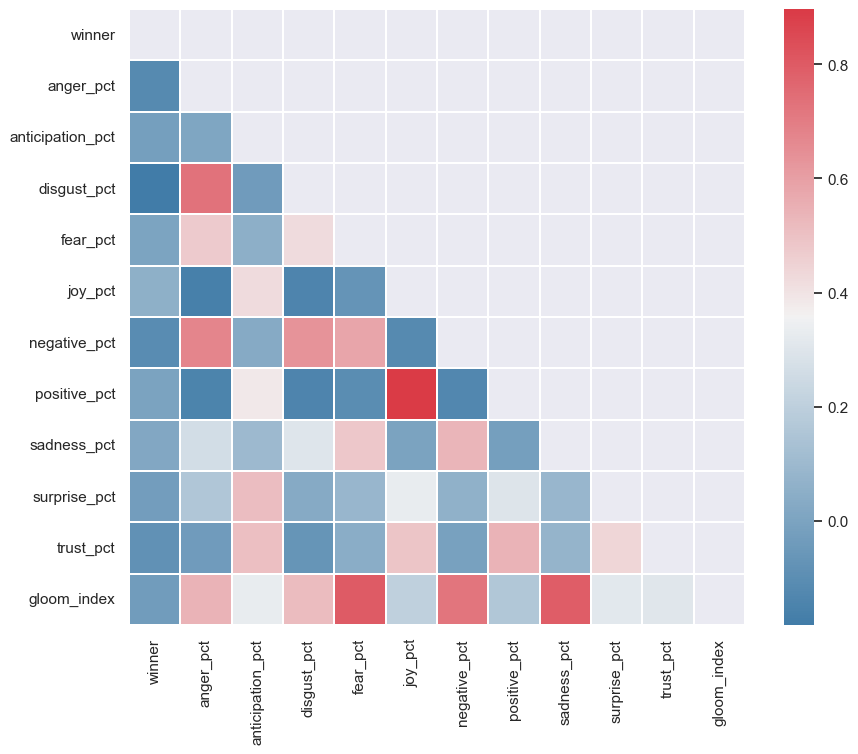

In [19]:
df_corr = df_english.drop(['title', 'artist', 'lyrics', 'preprocessed_lyrics', 'year', 'language'], axis=1)

sns.set_theme(style="dark")

corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.2) 


In [20]:
df_corr.dropna(axis=1,inplace=True)

In [21]:
import statsmodels.api as sm

# set up the linear regression model
y = df_corr['winner']
X = df_corr.drop(['winner'],axis=1)
X = sm.add_constant(X)  # add an intercept term to the model

# fit the linear regression model
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 winner   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.595
Date:                Wed, 01 Mar 2023   Prob (F-statistic):            0.00487
Time:                        20:19:15   Log-Likelihood:                -145.23
No. Observations:                 331   AIC:                             312.5
Df Residuals:                     320   BIC:                             354.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3051      0.057  

In [22]:
analysis_df = pd.read_csv('english_df.csv')
analysis_df.head(5)


,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,gloom_index
0,If I Ever Lose My Faith In You (Single),Sting,0,1993,Sorrow (syrup rmx) Yea\nUh huh\nAbstract Art\n...,sorrow ( syrup rmx ) yea uh huh abstract art f...,en,0.047511,0.067873,0.052036,0.095023,0.049774,0.117647,0.088235,0.076923,0.033937,0.063348,100.000000
1,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,translationshrvatskitürkçesvenskaespañolрусски...,en,0.082474,0.030928,0.082474,0.082474,0.025773,0.097938,0.025773,0.097938,0.015464,0.025773,97.722619
2,Not Ready To Make Nice,Dixie Chicks,1,2006,"Not Ready to Make Nice \nForgive, sounds good\...","readi make nice forgiv , sound good forget , '...",en,0.061321,0.061321,0.061321,0.070755,0.042453,0.113208,0.047170,0.094340,0.014151,0.047170,94.855395
3,Help Me (Single),Joni Mitchell,0,1974,Lilith \nSeptember\nDont rain on me\nDont thro...,lilith septemb dont rain dont throw back ocean...,en,0.020690,0.055172,0.027586,0.089655,0.041379,0.110345,0.055172,0.089655,0.013793,0.048276,93.863111
4,Paper Planes,M.I.A,0,2008,"Paper Planes \nI fly like paper, get high like...","paper plane fli like paper , get high like pla...",en,0.083636,0.069091,0.021818,0.065455,0.047273,0.101818,0.061818,0.065455,0.069091,0.054545,85.060149


Word count.

In [23]:
stop = set(nltk.corpus.stopwords.words('english'))

In [24]:
# stem lyrics
analysis_df['preprocessed_lyrics'] = analysis_df['preprocessed_lyrics'].str.replace(r'[^a-zA-Z\s]', '')
analysis_df['preprocessed_lyrics'] = analysis_df['preprocessed_lyrics'].str.lower().str.split()
analysis_df['preprocessed_lyrics'] = analysis_df['preprocessed_lyrics'].apply(lambda x: [item for item in x if item not in stop])

# get word count
analysis_df['word_count'] = analysis_df['preprocessed_lyrics'].str.len()
analysis_df = analysis_df[analysis_df['word_count'] <= 500]
analysis_df.head()

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66123/1476916778.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  analysis_df['preprocessed_lyrics'] = analysis_df['preprocessed_lyrics'].str.replace(r'[^a-zA-Z\s]', '')


,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,fear_pct,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,gloom_index,word_count
0,If I Ever Lose My Faith In You (Single),Sting,0,1993,Sorrow (syrup rmx) Yea\nUh huh\nAbstract Art\n...,"[sorrow, syrup, rmx, yea, uh, huh, abstract, a...",en,0.047511,0.067873,0.052036,0.095023,0.049774,0.117647,0.088235,0.076923,0.033937,0.063348,100.000000,392
1,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,[translationshrvatskitrkesvenskaespaolromnport...,en,0.082474,0.030928,0.082474,0.082474,0.025773,0.097938,0.025773,0.097938,0.015464,0.025773,97.722619,153
2,Not Ready To Make Nice,Dixie Chicks,1,2006,"Not Ready to Make Nice \nForgive, sounds good\...","[readi, make, nice, forgiv, sound, good, forge...",en,0.061321,0.061321,0.061321,0.070755,0.042453,0.113208,0.047170,0.094340,0.014151,0.047170,94.855395,170
3,Help Me (Single),Joni Mitchell,0,1974,Lilith \nSeptember\nDont rain on me\nDont thro...,"[lilith, septemb, dont, rain, dont, throw, bac...",en,0.020690,0.055172,0.027586,0.089655,0.041379,0.110345,0.055172,0.089655,0.013793,0.048276,93.863111,132
4,Paper Planes,M.I.A,0,2008,"Paper Planes \nI fly like paper, get high like...","[paper, plane, fli, like, paper, get, high, li...",en,0.083636,0.069091,0.021818,0.065455,0.047273,0.101818,0.061818,0.065455,0.069091,0.054545,85.060149,213


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66123/1557533563.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=analysis_df, x='year', y='word_count', hue='winner', ci=None)


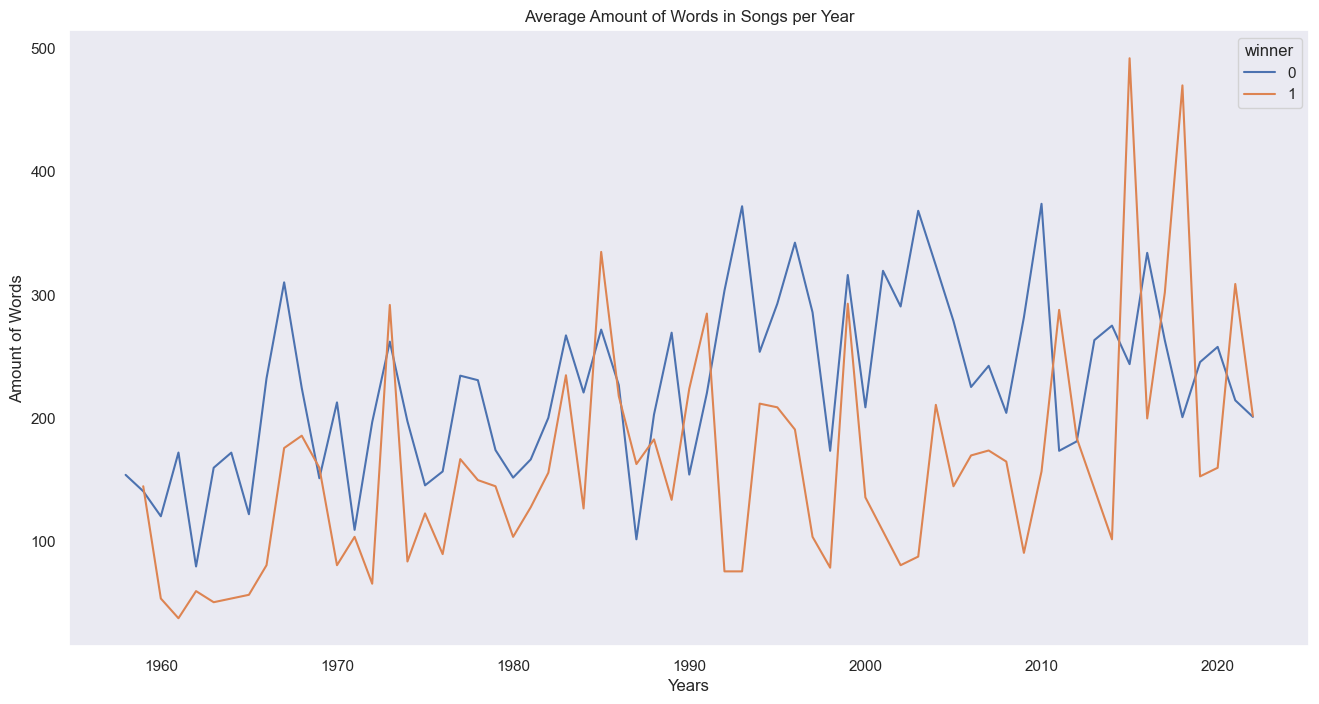

In [25]:
# Plot the average word count for each year
plt.figure(figsize=(16,8))
sns.lineplot(data=analysis_df, x='year', y='word_count', hue='winner', ci=None)
plt.title('Average Amount of Words in Songs per Year')
plt.xlabel('Years')
plt.ylabel('Amount of Words')
plt.show()


In [26]:
def count_unique_words(lst):
    return len(set(lst))

# apply the function to create a new column
analysis_df['unique_word_count'] = analysis_df['preprocessed_lyrics'].apply(lambda x: count_unique_words(x))


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66123/85108535.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=analysis_df, x='year', y='unique_word_count', hue='winner', ci=None)


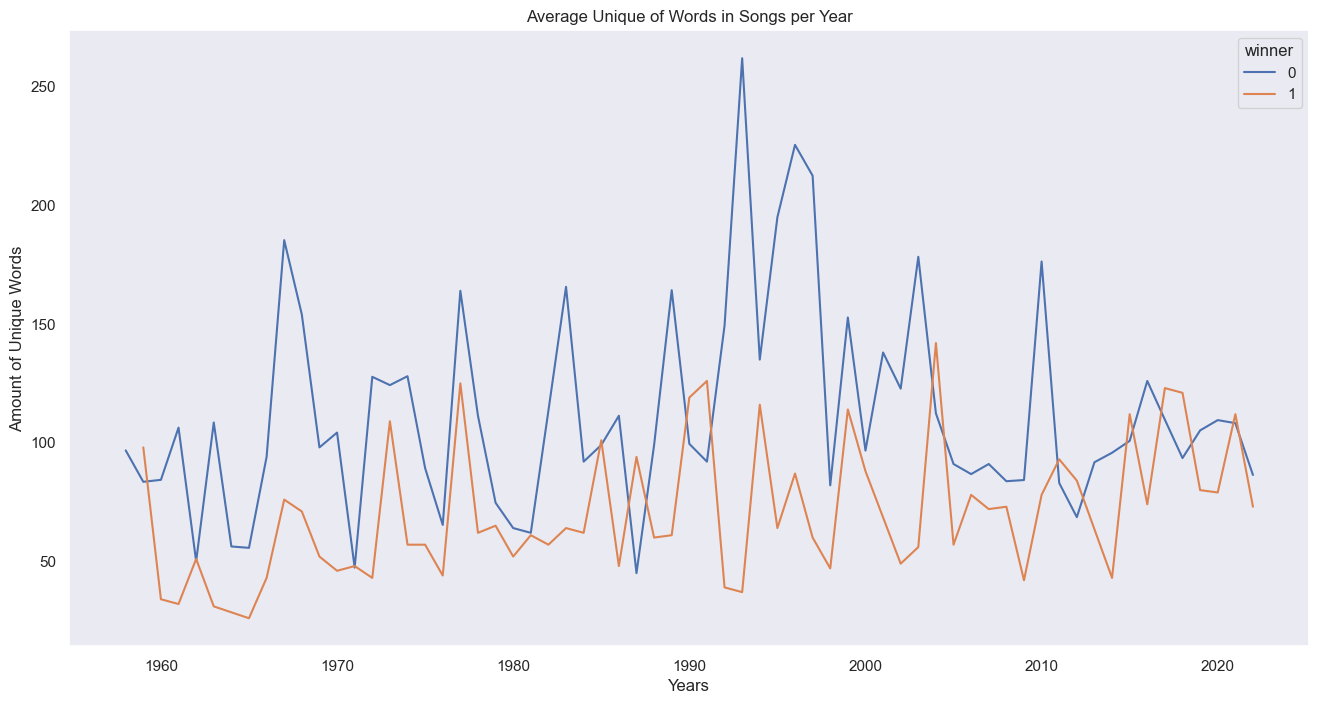

In [27]:
# Plot the average amount of unique words each year
plt.figure(figsize=(16,8))
sns.lineplot(data=analysis_df, x='year', y='unique_word_count', hue='winner', ci=None)
plt.title('Average Unique of Words in Songs per Year')
plt.xlabel('Years')
plt.ylabel('Amount of Unique Words')
plt.show()


Profanity over the decades.

In [28]:
# add decades detail
# Define the decade-to-year range mapping
decade_map = {'50s': (1950, 1960),
              '60s': (1960, 1970),
              '70s': (1970, 1980),
              '80s': (1980, 1990),
              '90s': (1990, 2000),
              '00s': (2000, 2010),
              '10s': (2010, 2020),
              '20s': (2020, 2030)}

# Apply the mapping using the `map()` method
def get_decade(year):
    for key, value in decade_map.items():
        if value[0] <= year < value[1]:
            return key
    return 'unknown'

analysis_df['decade'] = analysis_df['year'].apply(get_decade)

In [29]:
decades = ['50s', '60s', '70s', '80s', '90s', '00s', '10s', '20s']
common_words = {}

for decade in decades:
    # Filter the DataFrame by decade
    df_decade = analysis_df.loc[analysis_df['decade'] == decade]
    # Join the cleaned lyrics of all songs in the decade
    for i in range(len(df_decade['preprocessed_lyrics'])):
        lyrics = ' '.join(df_decade['preprocessed_lyrics'].iloc[0]).split()
    # Count the occurrences of each word and take the 200 most common words
        common_words[decade] = Counter(lyrics).most_common(200)

commonWords50 = common_words['50s']
commonWords60 = common_words['60s']
commonWords70 = common_words['70s']
commonWords80 = common_words['80s']
commonWords90 = common_words['90s']
commonWords00 = common_words['00s']
commonWords10 = common_words['10s']
commonWords20 = common_words['20s']

https://github.com/coffee-and-fun/google-profanity-words

In [30]:
url  = 'https://raw.githubusercontent.com/coffee-and-fun/google-profanity-words/main/data/list.txt'
google_profanity_words = request.urlopen(url)

profane_words = []
for line in google_profanity_words:
    profane_words.append(line.decode("utf-8").strip())

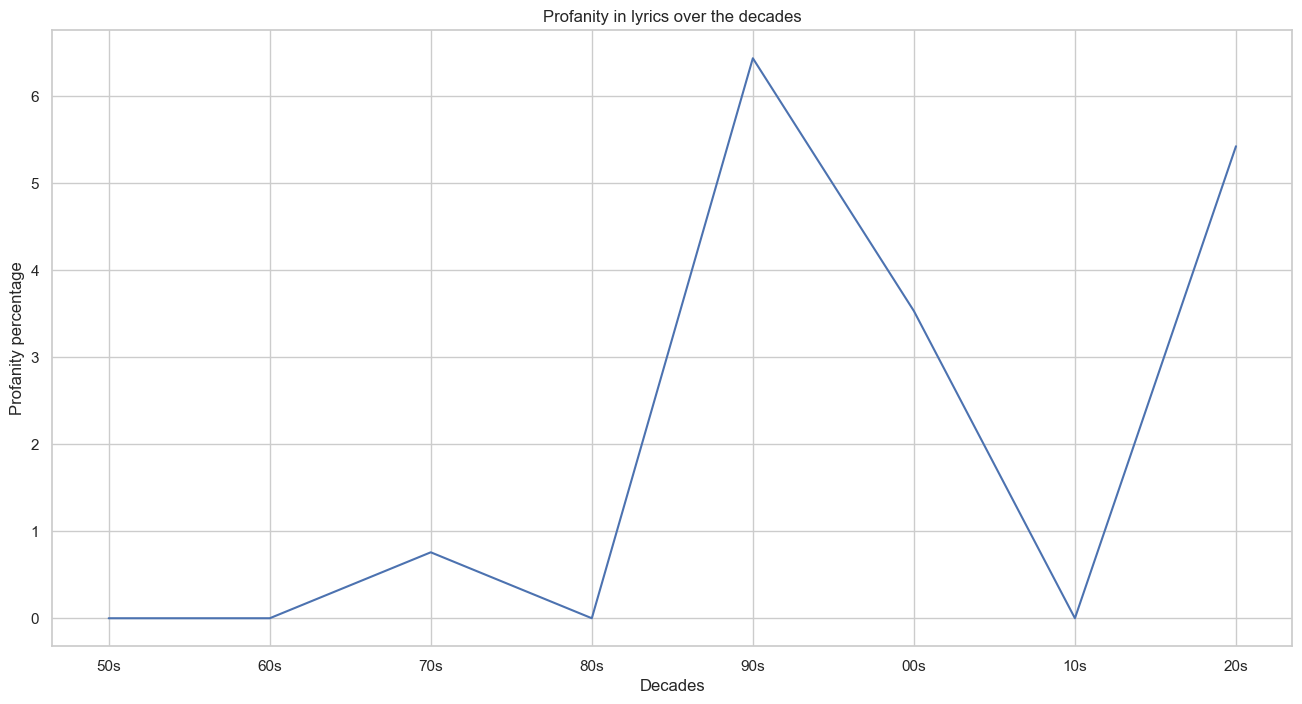

In [31]:
commonWords = [commonWords50, commonWords60, commonWords70, commonWords80, commonWords90, commonWords00, commonWords10, commonWords20]
counts = []
for item in commonWords:
    totalCount = 0
    count = 0
    for key,value in item:
        if key in profane_words:
            count += value
        totalCount += value
    counts.append(count/totalCount * 100)

profanity_dict = {}
for i, decade in enumerate(decades):
    profanity_dict[decade] = counts[i]

profanity_df = pd.DataFrame.from_dict(profanity_dict, orient='index', columns=['Profanity Percentage'])

sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
sns.lineplot(data=profanity_df, x=profanity_df.index, y='Profanity Percentage')
plt.title("Profanity in lyrics over the decades")
plt.xlabel("Decades")
plt.ylabel("Profanity percentage")
plt.show()




Wordcloud.

In [32]:
winner_df = analysis_df[analysis_df.winner==1]
nominee_df = analysis_df[analysis_df.winner==0]

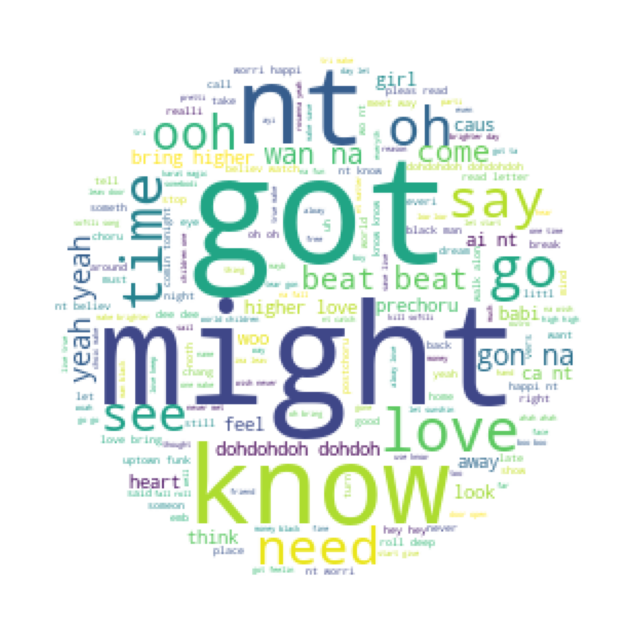

In [33]:
#convert list to string and generate

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

unique_string = ' '.join(winner_df['preprocessed_lyrics'].sum())
wordcloud = WordCloud(background_color="white",
                      mask=mask,
                      width = 1000,
                      height = 500).generate(unique_string)
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

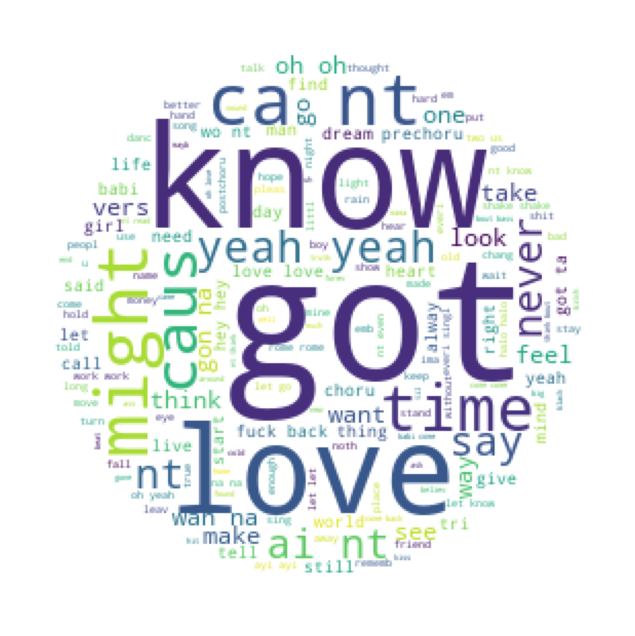

In [34]:
#convert list to string and generate

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

unique_string = ' '.join(nominee_df['preprocessed_lyrics'].sum())
wordcloud = WordCloud(background_color="white",
                      mask=mask,
                      width = 1000,
                      height = 500).generate(unique_string)
plt.figure(figsize=(19,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Multiple Grammy winners.
Can you guess who has won more than 1 Grammy Best Record?

In [35]:
dupes = analysis_df[analysis_df.winner==1]
dupes = dupes[dupes['artist'].duplicated(keep=False)]
dupes.sort_values('artist')

,title,artist,winner,year,lyrics,preprocessed_lyrics,language,anger_pct,anticipation_pct,disgust_pct,...,joy_pct,negative_pct,positive_pct,sadness_pct,surprise_pct,trust_pct,gloom_index,word_count,unique_word_count,decade
201,"Up, Up And Away",5th Dimension,1,1967,TranslationsItalianoРусскийFrançaisNederlandsD...,[translationsitalianofranaisnederlandsdeutsche...,en,0.000001,0.024390,0.000001,...,0.016260,0.024390,0.048780,0.020325,0.000001,0.016260,25.604308,176,76,60s
290,Aquarius/Let The Sunshine In (The Flesh Failures),5th Dimension,1,1969,Aquarius / Let the Sunshine In (The Flesh Fail...,"[aquariu, let, sunshin, flesh, failur, part, a...",en,0.004630,0.023148,0.009259,...,0.037037,0.074074,0.083333,0.000001,0.013889,0.032407,13.727317,160,52,60s
118,Rolling In The Deep,Adele,1,2011,TranslationsFrançaisEspañolPortuguêsΕλληνικάRo...,"[translationsfranaisespaolportugusrol, deep, f...",en,0.014963,0.012469,0.014963,...,0.019950,0.047382,0.032419,0.047382,0.000001,0.014963,36.669738,288,93,10s
311,Hello,Adele,1,2016,TranslationsTürkçePortuguêsPortuguêsEspañolHel...,"[translationstrkeportugusportugusespaolhello, ...",en,0.000001,0.029316,0.000001,...,0.013029,0.006515,0.019544,0.009772,0.013029,0.013029,9.451634,200,74,10s
1,Bad Guy,Billie Eilish,1,2019,TranslationsHrvatskiTürkçeSvenskaEspañolРусски...,[translationshrvatskitrkesvenskaespaolromnport...,en,0.082474,0.030928,0.082474,...,0.025773,0.097938,0.025773,0.097938,0.015464,0.025773,97.722619,153,80,10s
92,Everything I Wanted,Billie Eilish,1,2020,TranslationsTürkçeEspañolРусскийRomânăPortuguê...,[translationstrkeespaolromnportuguspolskinorsk...,en,0.028708,0.019139,0.019139,...,0.009569,0.043062,0.019139,0.043062,0.004785,0.004785,40.569056,160,79,20s
12,Change The World,Eric Clapton,1,1996,TranslationsTürkçeEspañolPolskiItalianoFrançai...,[translationstrkeespaolpolskiitalianofranaisne...,en,0.063433,0.067164,0.033582,...,0.026119,0.074627,0.085821,0.055970,0.026119,0.037313,66.788718,191,87,90s
303,Tears In Heaven,Eric Clapton,1,1992,Tears in Heaven \nWould you know my name if I ...,"[tear, heaven, would, know, name, saw, heaven,...",en,0.000001,0.031915,0.000001,...,0.000001,0.021277,0.000000,0.021277,0.010638,0.000001,11.822253,76,39,90s
182,Days Of Wine And Roses,Henry Mancini,1,1963,Days of Wine and Roses The days of wine and ro...,"[day, wine, rose, day, wine, rose, laugh, run,...",en,0.000001,0.018182,0.000001,...,0.072727,0.000001,0.109091,0.036364,0.054545,0.054545,28.457635,51,31,60s
212,Moon River,Henry Mancini,1,1961,TranslationsEspañolMoon River [Verse]\nMoon ri...,"[translationsespaolmoon, river, vers, moon, ri...",en,0.020833,0.020833,0.000001,...,0.020833,0.041667,0.020833,0.020833,0.000001,0.020833,24.645504,38,32,60s


Gloom Index by year.

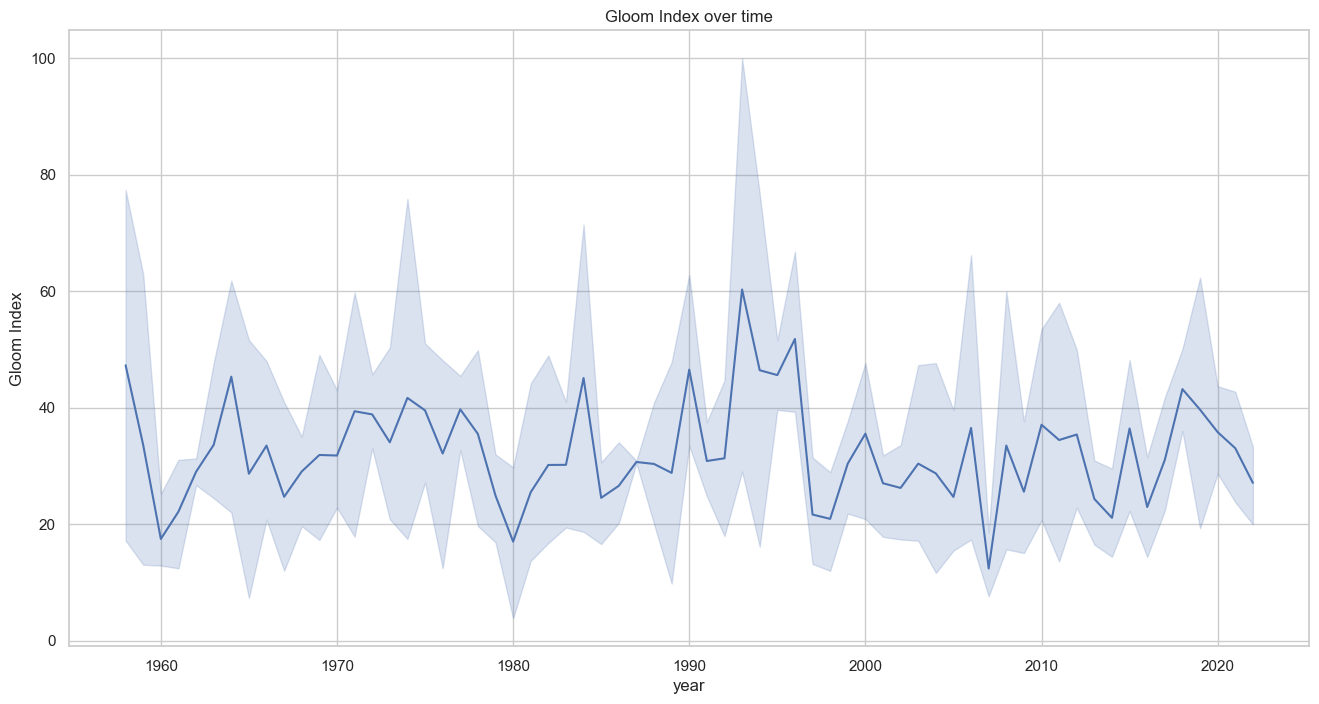

In [36]:
plt.figure(figsize=(16,8))
tg = sns.lineplot(data=analysis_df, x='year', y='gloom_index');
tg.set_ylabel("Gloom Index")
tg.set_title("Gloom Index over time")
plt.show()



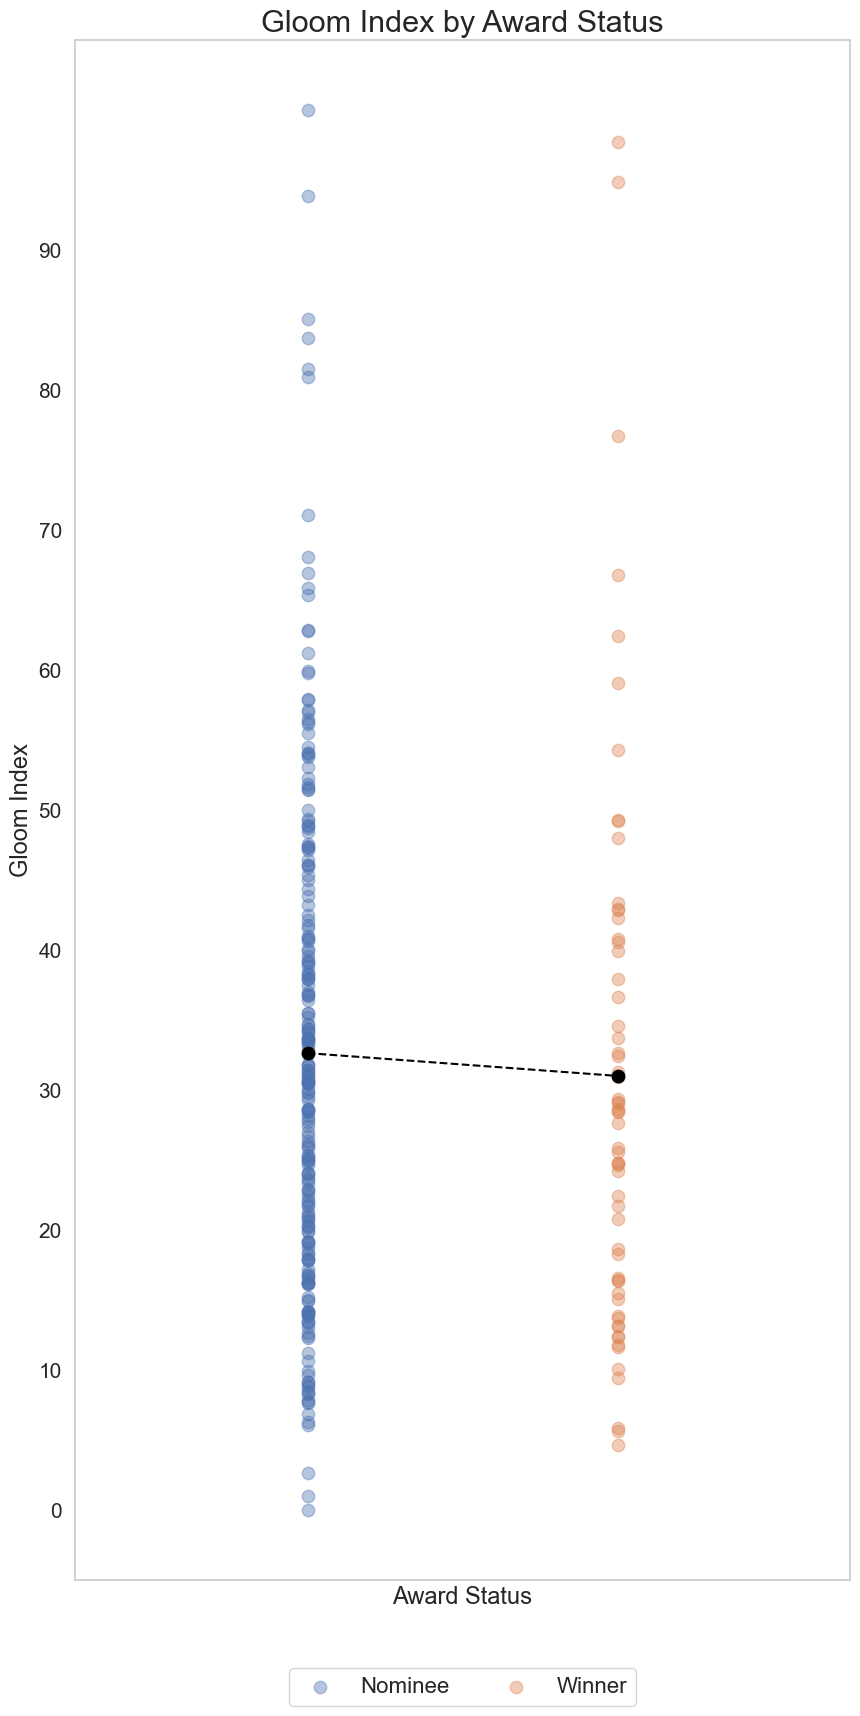

<module 'matplotlib.pyplot' from '/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [37]:
from make_diff_graph import make_diff_graph
from make_time_graph import make_time_graph

make_diff_graph(analysis_df)

<module 'matplotlib.pyplot' from '/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

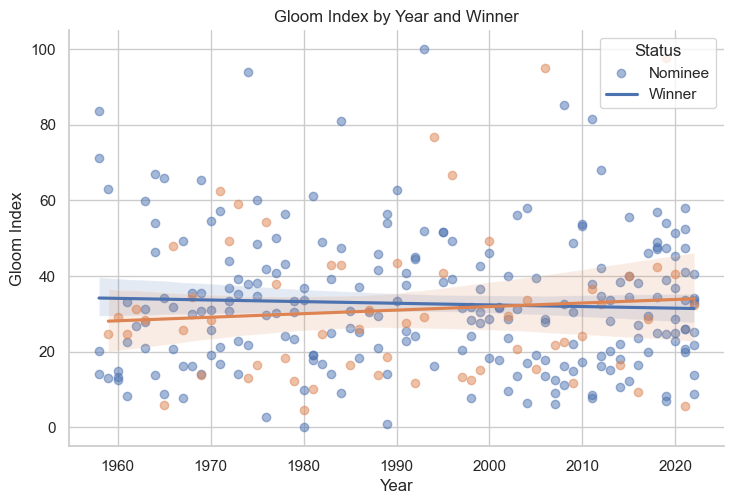

In [38]:
make_time_graph(analysis_df)

*Predictions: correlation between sentiment percentages and Grammy wins* 

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66123/1353268167.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(analysis_df.corr(),


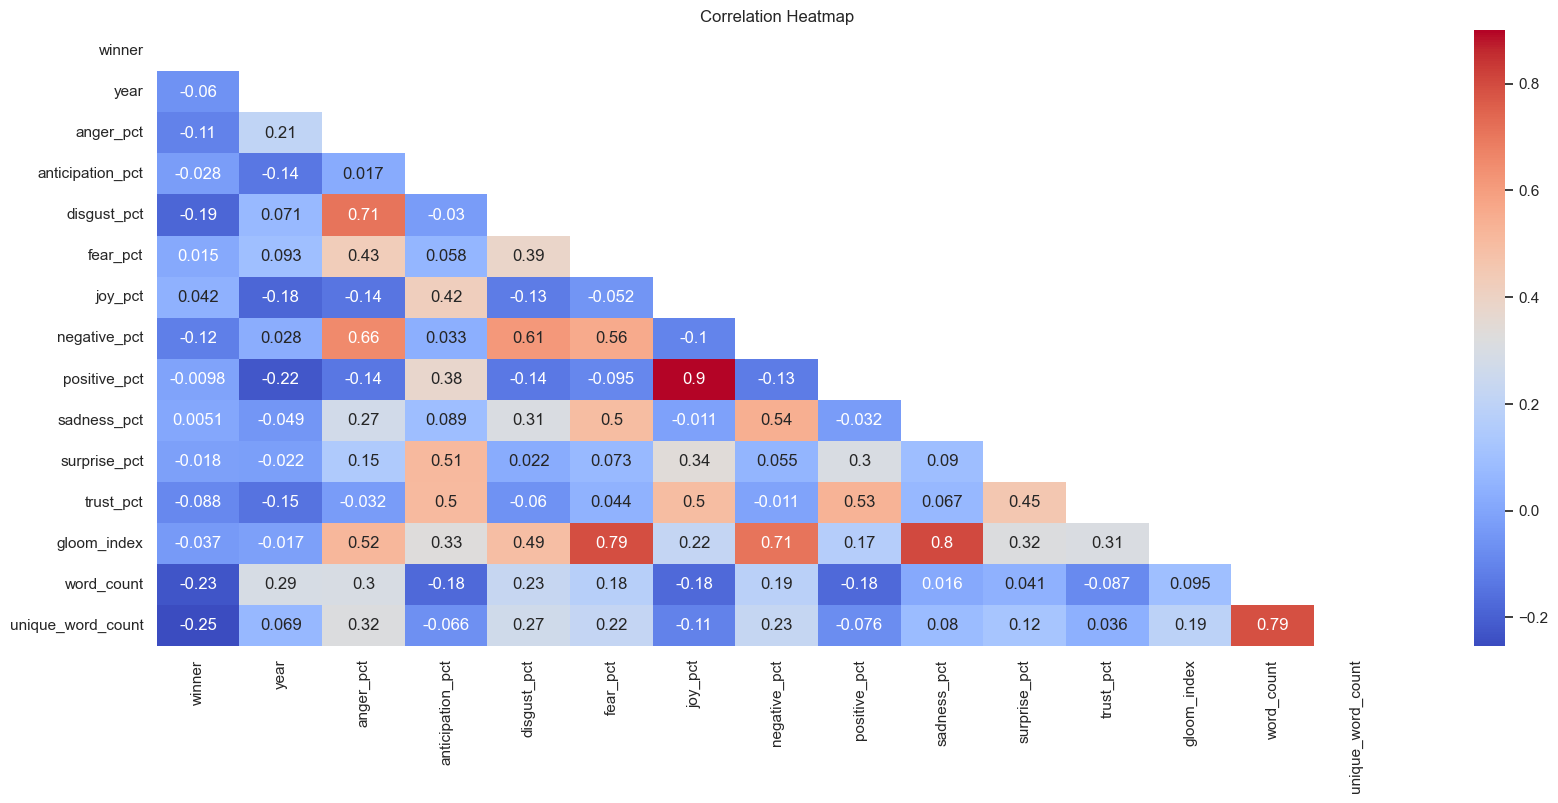

In [39]:
plt.figure(figsize = (20, 8))
mask = np.triu(np.ones_like(analysis_df.corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(analysis_df.corr(),
                      mask=mask,
                      annot=True,
                      cmap='coolwarm')
heatmap.set_title('Correlation Heatmap');

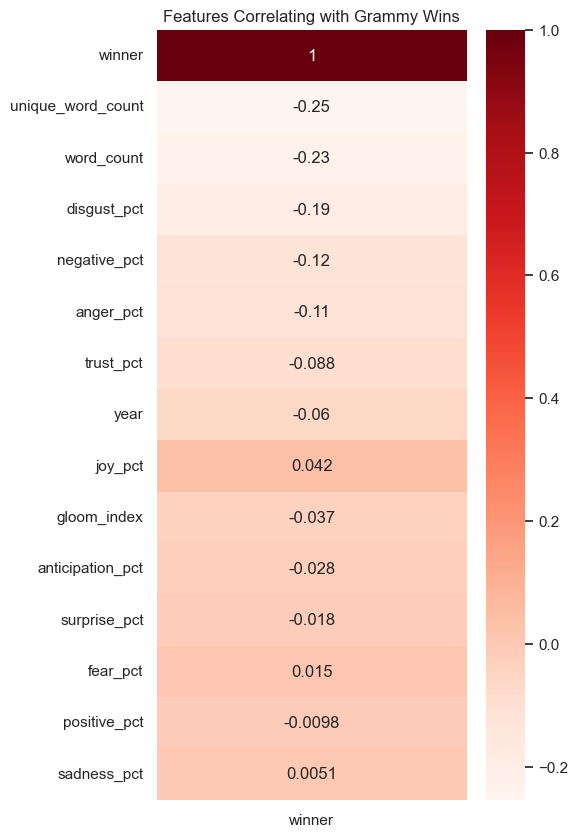

In [40]:
top_features = analysis_df.corr(numeric_only=True)[['winner']].sort_values(by='winner', key = abs, ascending=False)
plt.figure(figsize=(5, 10))
heatmap = sns.heatmap(top_features,
                      annot=True,
                      cmap='Reds')
heatmap.set_title('Features Correlating with Grammy Wins');
plt.yticks(rotation=0);

In [41]:
# split data set 
X = analysis_df.drop(['winner', 'title', 'artist', 'lyrics', 'preprocessed_lyrics', 'language', 'decade'], axis=1) 
y = analysis_df["winner"]  # This is the classification outcome: winner/nominee

# perform training and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# to print stats
feature_names = X.columns


In [42]:
# import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


# declare parameters
params = {
            # 'objective':'binary:logistic',
            # 'max_depth': 8,
            # 'alpha': 10,
            # 'learning_rate': 1.0,
            # 'n_estimators':200
            'solver': 'liblinear',
            'multi_class': 'ovr'
        }
            
# lr
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# svm
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

# decision tree
dt_clf = DecisionTreeClassifier(max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

# xg boost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

# check accuracy score
print('Logistic Regression model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, lr_pred)))
print('SVM model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, svm_pred)))
print('Decision Tree model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, dt_pred)))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, xgb_pred)))

Logistic Regression model accuracy score: 0.7586
SVM model accuracy score: 0.7586
Decision Tree model accuracy score: 0.7414
XGBoost model accuracy score: 0.7414
